In [1]:
# !pip install -r ../requirements.txt

## Importing Libraries

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("tab20")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

## Creating utility functions

In [3]:
def train_test_split(class0,class1,c0:int,c1:int,printshapes=True):
    '''This function returns X,y sets for training and testing.
    Inputs: 
    c0 = First c0 samples to be selected from class0 for training.
    c1 = First c1 samples to be selected from class1 for training.
    Outputs: Xtrain,Xtest,ytrain,ytest'''
    
    #Fetching the train and test sets
    train = pd.concat([class0[:c0],class1[:c1]],axis=0).sample(frac=1).reset_index(drop=True)
    test = pd.concat([class0[c0:],class1[c1:]],axis=0).sample(frac=1).reset_index(drop=True)
    
    #Dividing the sets into X,y: features,target
    Xtrain,ytrain = train.drop('class',axis=1),train['class']
    Xtest,ytest = test.drop('class',axis=1),test['class']
    
    if printshapes:
        #Printing shapes
        print("--------------------------------------------------")
        print("Shapes of Train and Test Sets:")
        print("XTrain Shape: ",Xtrain.shape)
        print("yTrain Shape: ",ytrain.shape)
        print("XTest Shape: ",Xtest.shape)
        print("yTest Shape: ",ytest.shape)
        print("--------------------------------------------------")
    
    return Xtrain,Xtest,ytrain,ytest


def find_k(Xtrain,Xtest,ytrain,ytest,k,p=2,weights='uniform',metric='minkowski',metric_params=None):
    '''
    Inputs: Xtrain,Xtest,ytrain,ytest and k: range of values to try for k
    Outputs: train_errors,test_errors,minimum_test_error,best k'''
    
    train_errors = []
    test_errors,min_test_error = [],np.inf
    model = None
    kopt = 0
    for kvalue in k:
        knn = KNeighborsClassifier(n_neighbors=kvalue,p=p,weights=weights,metric=metric,metric_params=metric_params)
        knn.fit(Xtrain,ytrain)
        ypred_train = knn.predict(Xtrain)
        ypred_test = knn.predict(Xtest)   
        test_error = 1-accuracy_score(ytest,ypred_test)
        if test_error < min_test_error:
           min_test_error=test_error 
           kopt = kvalue
           model = knn            
        train_errors.append(1-accuracy_score(ytrain,ypred_train))
        test_errors.append(test_error)
        
    return {'model':model,'train_error':train_errors,'test_error':test_errors,'min_test_error':min_test_error,'k':kopt}

def plot_train_test_errors(k:range,train_error:list,test_error:list):
    '''Plots train and test errors for different k'''
    plt.figure(figsize=(13,7))
    plt.plot(k,train_error,'midnightblue',label="train",marker='o',markersize=2)
    plt.plot(k,test_error,'r',label="test",marker='o',markersize=2)
    plt.axvline(k[np.argmin(test_error)],c='g',ls='-')
    plt.xlabel("Flexibility")
    plt.ylabel("Error")
    plt.title("Train vs Test Errors")
    plt.legend()
    plt.xlim(208,-10)
    plt.show()
    
def assess_model(ytest:list,ypred:list):
    '''This function assesses the model performance.
    Returns: Classification Report, True Positive Rate, True Negative Rate, Confusion Matrix'''
    #Classification Report
    print("Classification Report(Performance on Test Set):\n\n",classification_report(ytest,ypred))
    print("----------------------------------------------------------------------------------------")
    
    #TRUE POSITIVE/NEGATIVE RATE: Class 1 is considered positive here.
    tn,fp,fn,tp = confusion_matrix(ytest,ypred).ravel()
    true_pos_rate = tp/(tp+fn)
    true_neg_rate = tn/(tn+fp)
    print("True Positive Rate:",true_pos_rate)
    print("True Negative Rate:",true_neg_rate)
    print("----------------------------------------------------------------------------------------")
    
    #Plotting the confusion matrix
    plt.figure(figsize=(5,3.5))
    sns.heatmap(confusion_matrix(ytest,ypred),annot=True,cmap="Blues", fmt="d", 
                xticklabels = ['Normal(-)','Abnormal(+)'], 
                yticklabels = ['Normal(-)','Abnormal(+)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix",pad=15)
    plt.show()

# Homework 1

### The Dataset

### 1. Vertebral Column Data Set

This Biomedical data set was built by Dr. Henrique da Mota during a medical residence
period in Lyon, France. Each patient in the data set is represented in the data set
by six biomechanical attributes derived from the shape and orientation of the pelvis
and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle,
sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is
used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and
Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0
and AB=1.

### (a) Download the Vertebral Column Data Set from: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column

#### Reading data into a dataframe

In [4]:
df = pd.read_csv('../data/vertebral_column_data/column_2C.dat',sep=' ',header=None,index_col=False,\
                 names = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis', 'class'])
df.head(10)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
5,40.25,13.92,25.12,26.33,130.33,2.23,AB
6,53.43,15.86,37.17,37.57,120.57,5.99,AB
7,45.37,10.76,29.04,34.61,117.27,-10.68,AB
8,43.79,13.53,42.69,30.26,125.00,13.29,AB
9,36.69,5.01,41.95,31.68,84.24,0.66,AB


In [5]:
#Shape of data
df.shape

(310, 7)

In [6]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


In [7]:
#Checking for duplicates
df.duplicated().sum()

0

#### Replacing values: AB=1 and NO=0

In [8]:
df.replace(to_replace=["AB","NO"],value=[1,0],inplace=True)

### (b) Pre-Processing and Exploratory data analysis:

#### i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

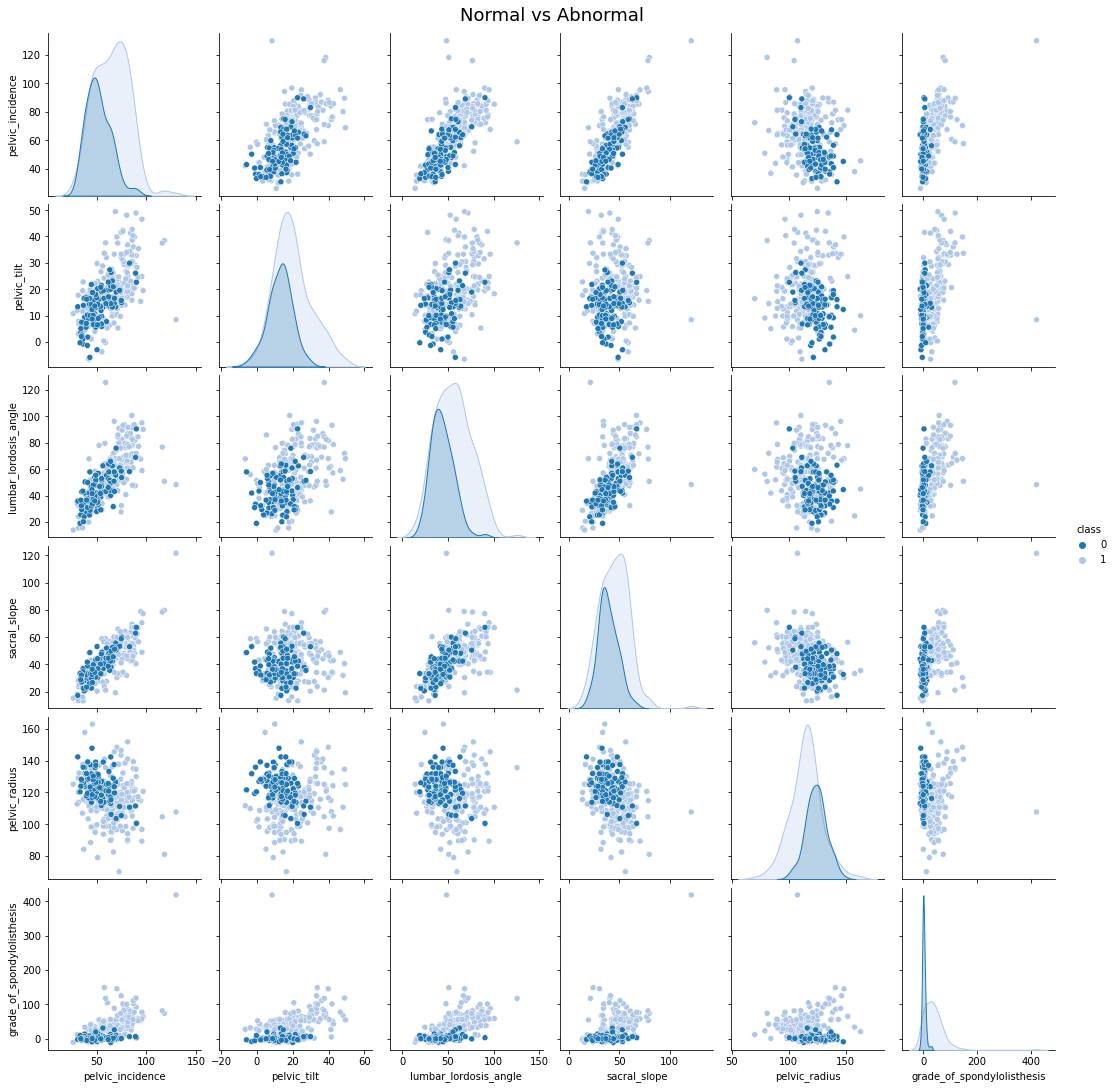

In [9]:
sns.pairplot(df,hue='class',vars=['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis'])
plt.suptitle("Normal vs Abnormal",y=1.01,fontsize=18)
plt.grid(True)
plt.show()

#### ii. Make boxplots for each of the independent variables. Use color to show classes 0 and 1 (see ISLR p. 129)

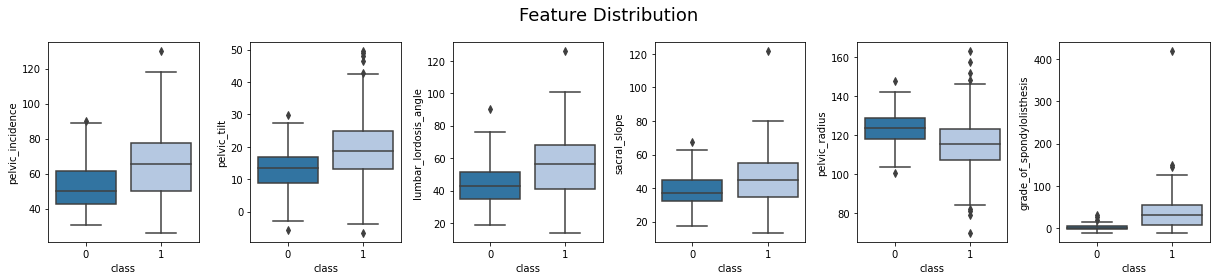

In [10]:
fig1, axes1 = plt.subplots(1,6,figsize=(17,3.5))
fcols = df.columns[:-1]
for i in range(len(fcols)):   
    sns.boxplot(data=df,x="class",y=fcols[i],ax=axes1[i])
fig1.tight_layout()
plt.suptitle("Feature Distribution",y=1.1,fontsize=18)
plt.show()

In [11]:
#Class distribution
df["class"].value_counts()

1    210
0    100
Name: class, dtype: int64

#### iii. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [12]:
#Getting individual class data
class0 = df.loc[df['class']==0]
class1 = df.loc[df['class']==1]

In [13]:
#train-test split
Xtrain,Xtest,ytrain,ytest = train_test_split(class0,class1,70,140,printshapes=True)

--------------------------------------------------
Shapes of Train and Test Sets:
XTrain Shape:  (210, 6)
yTrain Shape:  (210,)
XTest Shape:  (100, 6)
yTest Shape:  (100,)
--------------------------------------------------


### (c) Classification using KNN on Vertebral Column Data Set

#### i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

#### ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈ {208,205, . . . ,7,4,1}. (in reverse order). You are welcome to use smaller increments of k.

k:  4
Minimum test error 0.06


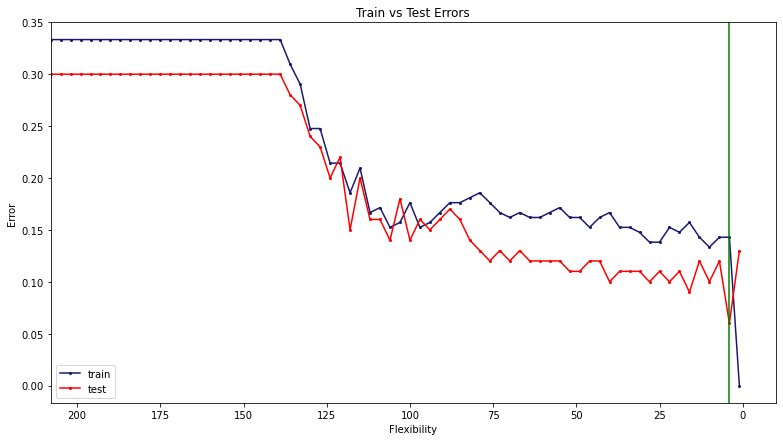

In [14]:
# Euclidean metric
m1 = find_k(Xtrain,Xtest,ytrain,ytest,k=range(208,0,-3),p=2,metric="minkowski")
print("k: ",m1['k'])
print("Minimum test error",round(m1['min_test_error'],4))

#Plotting train test errors
plot_train_test_errors(range(208,0,-3),train_error=m1['train_error'],test_error=m1['test_error'])

#### Which k ∗ is the most suitable k among those values? Cal-culate the confusion matrix, true positive rate, true negative rate, precision, and F 1 -score when k = k ∗ 

In [15]:
#A fitted KNN classifier with k*= 4 
m1['model']

KNeighborsClassifier(n_neighbors=4)

Classification Report(Performance on Test Set):

               precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.93      0.99      0.96        70

    accuracy                           0.94       100
   macro avg       0.95      0.91      0.93       100
weighted avg       0.94      0.94      0.94       100

----------------------------------------------------------------------------------------
True Positive Rate: 0.9857142857142858
True Negative Rate: 0.8333333333333334
----------------------------------------------------------------------------------------


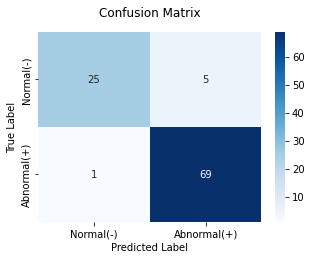

In [16]:
#Making predictions, Note: Class 1 means +ve here
assess_model(ytest,m1['model'].predict(Xtest))

In [17]:
print("Train Error:",round(1-accuracy_score(ytrain,m1['model'].predict(Xtrain)),3))

Train Error: 0.143


#### iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. 
Plot the best test error rate,which is obtained by some value of k, against the size of training set, when the size of training set is N∈ {10,20,30, . . . ,210}. Note: for each N, select your training set by choosing the first [N/3] rows of Class 0 and the first N− [N/3] rows of Class 1 in the training set you created in 1(b)iii. Also, for each N, select the optimal k from a set starting from k= 1, increasing by 5. For example, if N= 200, the optimal k is selected from {1,6,11, . . . ,196}.This plot is called a Learning Curve.

In [18]:
best_test_error_rate = []
i=0
n = range(10,210,10)
for nval in n:  
    #Fetching the train and test sets
    Xtrain1,Xtest1,ytrain1,ytest1 = train_test_split(class0,class1,nval//3,(nval-nval//3),printshapes=False)
    m2 = find_k(Xtrain1,Xtest,ytrain1,ytest,k=range(1,nval,5),p=2,metric='minkowski')
    best_test_error_rate.append(m2['min_test_error'])

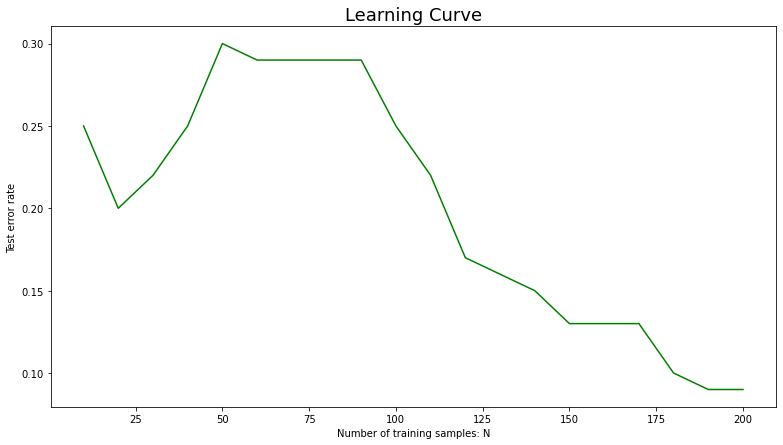

In [19]:
#Plotting best error rate
plt.figure(figsize = (13,7))
plt.plot(n,best_test_error_rate,'g')
plt.xlabel("Number of training samples: N")
plt.ylabel("Test error rate")
plt.title("Learning Curve",fontsize=18)
plt.show()

#### (d) Replace the Euclidean metric with the following metrics and test them. Summarize the test errors (i.e., when k = k ∗ ) in a table. Use all of your training data and select the best k when { 1 , 6 , 11 , . . . , 196 }.

i. Minkowski Distance:   

    A. which becomes Manhattan Distance with p = 1. 
    B. with log 10 ( p ) ∈ { 0 . 1 , 0 . 2 , 0 . 3 , . . . , 1 } . In this case, use the k ∗ you found for the Manhattan distance in 1(d)iA. What is the best log 10 ( p )? 
    C. which becomes Chebyshev Distance with p → ∞ 
    
ii. Mahalanobis Distance.

#### (i) A. which becomes Manhattan Distance with p = 1. 

In [20]:
# Manhattan Distance
m3 = find_k(Xtrain,Xtest,ytrain,ytest,k=range(1,197,5),p=1,metric="minkowski")
print("k: ",m3['k'])
print("Minimum Test Error: ",round(m3['min_test_error'],3))

k:  6
Minimum Test Error:  0.11


In [21]:
#Fitted best model 
m3['model']

KNeighborsClassifier(n_neighbors=6, p=1)

In [22]:
print("Train Error:",round(1-accuracy_score(ytrain,m3['model'].predict(Xtrain)),3))

Train Error: 0.138


#### B. with log 10 ( p ) ∈ { 0 . 1 , 0 . 2 , 0 . 3 , . . . , 1 } . In this case, use the k ∗ you found for the Manhattan distance in 1(d)iA. 

What is the best log 10 ( p )? 

In [23]:
#Fitting a new KNN classifier with 6 neighbors.
min_err = np.inf
p_best = 0
model = None
for p in np.power(10,np.arange(0.1,1.1,0.1)):
    knn = KNeighborsClassifier(n_neighbors=6,p=p)
    knn.fit(Xtrain,ytrain)
    ypred = knn.predict(Xtest)
    testerr = 1-accuracy_score(ytest,ypred)
    if testerr<min_err:
        min_err = testerr
        p_best = p
        model = knn

In [24]:
#Best value for log10p is
print(round(np.log10(p_best),2))

0.6


In [25]:
model

KNeighborsClassifier(n_neighbors=6, p=3.9810717055349722)

In [26]:
print("Test Error:",round(1-accuracy_score(ytest,model.predict(Xtest)),3))
print("Train Error:",round(1-accuracy_score(ytrain,model.predict(Xtrain)),3))

Test Error: 0.06
Train Error: 0.152


#### C. which becomes Chebyshev Distance with p → ∞

In [27]:
# Chebyshev Distance
m4 = find_k(Xtrain,Xtest,ytrain,ytest,k=range(1,197,5),p=np.inf,metric="minkowski")
print("k: ",m4['k'])
print("Minimum Test Error:",round(m4['min_test_error'],3))

k:  16
Minimum Test Error: 0.08


In [28]:
#Fitted model
m4['model']

KNeighborsClassifier(n_neighbors=16, p=inf)

In [29]:
print("Test Error:",round(1-accuracy_score(ytest,m4['model'].predict(Xtest)),3))
print("Train Error:",round(1-accuracy_score(ytrain,m4['model'].predict(Xtrain)),3))

Test Error: 0.08
Train Error: 0.152


#### ii.Mahalanobis Distance.

In [30]:
# Mahalanobis Distance
m5 = find_k(Xtrain,Xtest,ytrain,ytest,k=range(1,197,5),metric="mahalanobis",metric_params={'VI': np.linalg.pinv(Xtrain.cov())})
print("k: ",m5['k'])
print("Minimum Test Error:",round(m5['min_test_error'],3))

k:  1
Minimum Test Error: 0.17


In [31]:
#Getting the index for minimum k: k>1
i = np.where(m5['test_error'] == np.amin(m5['test_error']))[0][1]
k = range(1,197,5)[i]

In [32]:
print("k: ",k)
print("Minimum Test Error:",round(m5['test_error'][i],3))

k:  6
Minimum Test Error: 0.17


In [33]:
#Fitting a new KNN classifier with 6 neighbors.
knn1 = KNeighborsClassifier(n_neighbors=6,metric="mahalanobis",metric_params={'VI': np.linalg.pinv(Xtrain.cov())})
knn1.fit(Xtrain,ytrain)

KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 3.54692479e+04, -3.54704193e+04,  4.81000030e-02,
        -3.54712634e+04, -8.86924247e-01,  4.22953065e-01],
       [-3.54704193e+04,  3.54716081e+04, -5.35124516e-02,
         3.54724418e+04,  8.88507004e-01, -4.24617106e-01],
       [ 4.81000030e-02, -5.35124516e-02,  8.04118769e-03,
        -5.54682960e-02, -1.81467220e-03,  3.60680605e-04],
       [-3.54712634e+04,  3.54724418e+04, -5.54682960e-02,
         3.54732953e+04,  8.91305989e-01, -4.25404424e-01],
       [-8.86924247e-01,  8.88507004e-01, -1.81467220e-03,
         8.91305989e-01,  8.80653540e-03, -6.72591602e-04],
       [ 4.22953065e-01, -4.24617106e-01,  3.60680605e-04,
        -4.25404424e-01, -6.72591602e-04,  1.18064473e-03]])},
                     n_neighbors=6)

In [34]:
print("Test Error:",round(1-accuracy_score(ytest,knn1.predict(Xtest)),3))
print("Train Error:",round(1-accuracy_score(ytrain,knn1.predict(Xtrain)),3))

Test Error: 0.17
Train Error: 0.119


#### (e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors whenk∈ {1,6,11,16, . . . ,196}.

In [35]:
for d,p in zip(['euclidean','manhattan','chebyshev'],[2,1,np.inf]):

    m7 = find_k(Xtrain,Xtest,ytrain,ytest,weights="distance",k=range(1,197,5),p=p,metric=d)
    print("\n------------------\n",d)
    print("Min_test_error:",m7['min_test_error'])
    print("Best k:",m7['k'])


------------------
 euclidean
Min_test_error: 0.09999999999999998
Best k: 6

------------------
 manhattan
Min_test_error: 0.09999999999999998
Best k: 26

------------------
 chebyshev
Min_test_error: 0.10999999999999999
Best k: 16


#### (f) What is the lowest training error rate you achieved in this homework?

Considering the models that were trained on optimal value for k, the lowest training error received was **0.119 for k=6 and distance = mahalanobis**. However, the testing error increased.

**In general, the minimum training error is 0** if we disregard the testing error. Usually this happened with k=1/overfitting cases.